### Libraries

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing TensorFlow and Keras components
import tensorflow as tf
from keras.applications import EfficientNetB7  # Importing EfficientNetB7 model
from keras.preprocessing.image import ImageDataGenerator  # Importing ImageDataGenerator for image preprocessing
from keras.models import Sequential  # Importing Sequential and Model classes from Keras
from keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, GRU  # Importing various layers from Keras
    
)

# Importing additional components
from keras import regularizers
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

pip install 'aif360[LawSchoolGPA]'


### Settings

In [2]:
### ---------------- Paths ---------------- ###

# IP102 path
ip_102_path = "../../../Data/MSiA 432/03_hw/IP102-Dataset/"

# FairFace path
fair_face_path = "../../../Data/MSiA 432/03_hw/FairFace/"

### ---------------- GPU(s) ---------------- ###

# Select GPU(s)
gpus = (0,) # Example: Set as (0, 1, 3) to use 1st, 2nd, and 4th GPUs - Currently (0,) because I have 1 GPU

# Function to set which GPUs are visible to TensorFlow
def set_gpus(*gpu_indices):
    # Get list of GPUs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))

    if gpus:
        visible_gpus = [gpus[i] for i in gpu_indices]
        try:
            # Only use specified GPUs and ignore the others
            tf.config.experimental.set_visible_devices(visible_gpus, 'GPU')
            for gpu in visible_gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Using GPUs: ", [gpu.name for gpu in visible_gpus])
        except RuntimeError as e:
            print(e)
    return visible_gpus

# Call the function with the indices of the GPUs you want to use
visible_gpus = set_gpus(*gpus)  # Use the second, third, fourth, and fifth GPU

# Extract names of the GPUs being used
gpu_names = ['/device:GPU:' + gpu.name.split(':')[-1] for gpu in visible_gpus]
print(gpu_names)

Num GPUs Available:  1
Using GPUs:  ['/physical_device:GPU:0']
['/device:GPU:0']


# Question 1

In word document attatched with this submission

# Question 2

## a. Data Preprocessing

### Get file locations

In [3]:
# Define the column names for the DataFrame
columns = ["img_path", "target"]

# Read the training, validation and test data from text files into respective DataFrames
train_df = pd.read_csv(ip_102_path + "train.txt", header=None, sep=" ", names=columns)
val_df = pd.read_csv(ip_102_path + "val.txt", header=None, sep=" ", names=columns)
test_df = pd.read_csv(ip_102_path + "test.txt", header=None, sep=" ", names=columns)

# Preprocess each DataFrame (train_df, val_df, test_df) 
for df in [train_df, val_df, test_df]:
    # Convert the 'target' column to string type, to handle it as categorical data
    df.target = df.target.astype(str)
    
    # Update 'img_path' column to include 'target' as subfolder, for accessing the image files
    df['img_path'] = df['target'].astype(str) + '/' + df['img_path']

# Get the number of unique target classes in the training data, to know the dimensionality of the classification problem
num_classes = len(train_df.target.unique())

# Print the first few rows of the training DataFrame, to check its structure
train_df.head()

,img_path,target
0,0/00002.jpg,0
1,0/00003.jpg,0
2,0/00005.jpg,0
3,0/00006.jpg,0
4,0/00008.jpg,0


### Plot Distribution of Classes

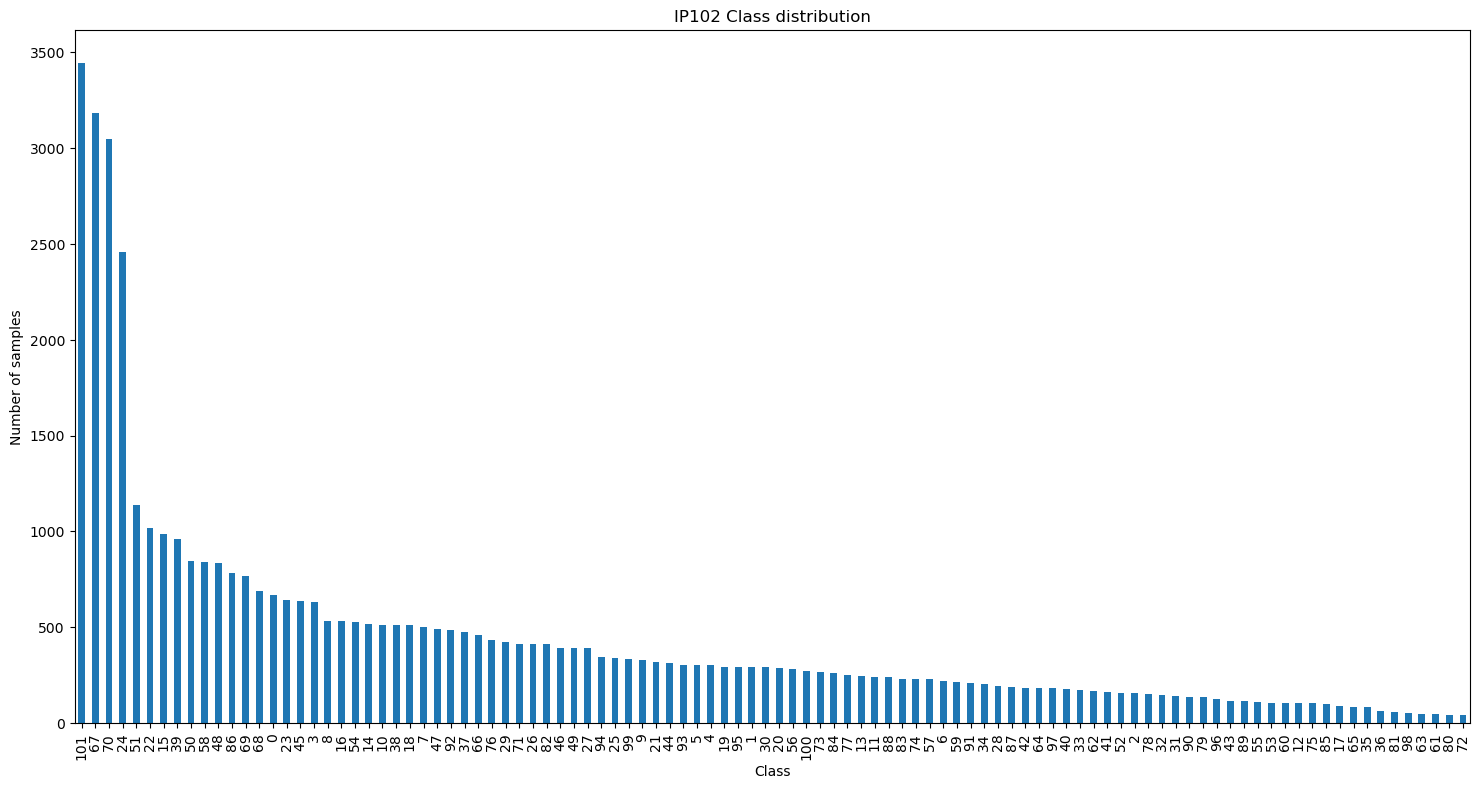

In [4]:
# Calculate the frequency of each class in the target column of the training set, to understand class distribution
class_counts = train_df['target'].value_counts()

# Plot class distribution for visualization
plt.figure(figsize=(18, 9))
class_counts.plot(kind='bar')
plt.title('IP102 Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

### Prepare Images for CNN

In [5]:
# Define ImageDataGenerator for training (with data augmentation) to improve model generalization
train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values to [0,1]
        rotation_range=20,  # Randomly apply rotations
        zoom_range=0.05,  # Randomly apply zoom
        width_shift_range=0.05,  # Randomly shift images horizontally
        height_shift_range=0.05,  # Randomly shift images vertically
        shear_range=0.05,  # Randomly apply shear transformations
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode="nearest")  # Set strategy for filling in newly created pixels

# Define ImageDataGenerator for validation and testing (without augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0,1]

In [6]:
# Set the batch size for the generators
batch_size = 32

# Create data generators for training, validation and testing
# These will be used to supply data to the model during training/validation/testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(ip_102_path, "classification/train"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(ip_102_path, "classification/val"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.path.join(ip_102_path, "classification/test"),
    x_col="img_path",
    y_col="target",
    target_size=(100, 100),
    batch_size=1,
    class_mode="categorical",
    shuffle=True
)

Found 45095 validated image filenames belonging to 102 classes.
Found 7508 validated image filenames belonging to 102 classes.
Found 22619 validated image filenames belonging to 102 classes.


## b. Custom Model

### Hyperparameters

In [7]:
# Training paramaters
input_shape = (100, 100, 3)
optimizer = "adam"
loss = "categorical_crossentropy"
metrics = ["accuracy"]
epochs = 25
regs = (0.00001, 0.00001)

### Hyperparameter and Layer Reasoning:

1. **Optimizer**: Adam was chosen as the optimizer for this model due to its adaptive learning rate properties. By individually adapting the learning rates, Adam often leads to better performance in comparison to other optimizers such as SGD.

2. **Loss function**: The categorical cross-entropy loss was used for this model as it is typically suitable for multi-class classification problems. This function compares the model's prediction probabilities with the true label, making it suitable for training models to predict probabilities in a multi-class setting.

3. **Metrics**: Accuracy was chosen as the evaluation metric because this model is designed for multi-class classification. Accuracy is a common and straightforward metric for this kind of task.

4. **Number of filters and filter size in Conv2D**: The model starts with 32 filters and doubles to 64 filters in the second Conv2D layer. This design is based on the common practice of increasing the model's capacity while moving deeper into the network. The filter size of (3,3) was chosen as it is a standard choice that balances computational efficiency and the ability to learn spatial hierarchies.

5. **Pool size in MaxPooling2D**: A pool size of (2,2) is used to reduce the spatial dimensions of the input. This can reduce the amount of computation needed, as well as making the learned representations more robust to small translations in the input image.

6. **Dropout rates**: Dropout rates of 0.25 and 0.5 were selected to prevent overfitting. The higher dropout rate is used in the fully connected layer, which often contains more parameters and hence requires more regularization.

7. **Number of nodes in the first Dense layer**: A size of 512 was chosen for the first dense layer. This choice offers a balance between computational efficiency and the model's capacity to learn from the data. Depending on the complexity of the problem and the size of the dataset, this number can be adjusted to achieve better performance.

8. **Activation functions**: The ReLU activation function was chosen for the hidden layers because it can mitigate the vanishing gradient problem during backpropagation. On the other hand, the softmax activation was used in the output layer to output a valid probability distribution for the predicted classes.

9. **Regularizers in Conv2D**: L1 and L2 regularizers are applied to the convolutional layers, this helps in penalizing large weights and thus, reduces overfitting. The regularization rates regs[0] and regs[1] can be tuned based on the amount of overfitting observed in the model's performance. Regularization helps in keeping the model weights small, thereby improving the model's generalization capabilities.

### Create and Fit CNN

In [8]:
# Create a MirroredStrategy for distributed training across multiple GPUs
strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

def create_model(input_shape, num_classes, regs):

    model = Sequential([

        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1_l2(l1=regs[0], l2=regs[1])),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),

    ], name="Q2_Custom_CNN")

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Open the strategy scope
with strategy.scope():
    model = create_model(input_shape, num_classes, regs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


### Model Architecture Summary:

This Convolutional Neural Network (CNN) model follows a classic structure of stacking convolutional layers followed by max pooling and dropout for the purpose of feature extraction, ending with a flatten layer, dense layers, and a final classification layer. The model utilizes TensorFlow's Keras API, making it clear and easily reproducible.

1. **Conv2D Layers**: The model begins with two sets of Conv2D layers. The first set uses 32 filters of 3x3 size, a ReLU activation function, and L1 and L2 regularization. The second set consists of two additional Conv2D layers with 64 filters, again of 3x3 size, and ReLU activation. These layers are designed to extract important features from the input data.

2. **MaxPooling2D Layers**: Each set of Conv2D layers is followed by a MaxPooling2D layer with a pool size of 2x2, effectively downsampling the input by taking the maximum value over the window defined by pool size for each dimension along the features axis.

3. **Dropout Layers**: Following the MaxPooling2D layers are Dropout layers with dropout rates of 0.25, respectively, randomly setting a fraction of input units to 0 at each update during training time, which helps prevent overfitting.

4. **Flatten Layer**: The model includes a Flatten layer, which converts the 2D matrix data to a vector. This layer does not affect the batch size.

5. **Dense Layers**: After the Flatten layer, the model has a Dense layer with 512 nodes using a ReLU activation function. This is followed by another Dropout layer, this time with a rate of 0.5, and then another Dense layer, the size of which is determined by the number of classes in the dataset.

6. **Output Layer**: The output layer is a Dense layer with a number of nodes equal to the number of classes. This layer uses a softmax activation function, making it suitable for multiclass classification tasks.


In [9]:
model.summary()

Model: "Q2_Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        36928     
                                                     

### Number of Parameters in Each Layer:

Each layer in the model contributes a number of trainable parameters. Here's the breakdown for each layer:

1. **First Conv2D layer**:
    - Number of filters: 32
    - Each filter size: 3x3
    - Input depth (channels): 3 (assuming RGB images)
    - Parameters per filter: 3 * 3 * 3 = 27 (weights) + 1 (bias)
    - Total parameters: 32 * (27 + 1) = 896

</br>

2. **Second Conv2D layer**:
    - Number of filters: 32
    - Each filter size: 3x3
    - Input depth (channels): 32 (output from previous layer)
    - Parameters per filter: 3 * 3 * 32 = 288 (weights) + 1 (bias)
    - Total parameters: 32 * (288 + 1) = 9248

</br>

3. **MaxPooling2D and Dropout layers**:
    - These layers don't have trainable parameters.

</br>

4. **Third Conv2D layer**:
    - Number of filters: 64
    - Each filter size: 3x3
    - Input depth (channels): 32 (output from previous Conv2D layer)
    - Parameters per filter: 3 * 3 * 32 = 288 (weights) + 1 (bias)
    - Total parameters: 64 * (288 + 1) = 18496

</br>

5. **Fourth Conv2D layer**:
    - Number of filters: 64
    - Each filter size: 3x3
    - Input depth (channels): 64 (output from previous layer)
    - Parameters per filter: 3 * 3 * 64 = 576 (weights) + 1 (bias)
    - Total parameters: 64 * (576 + 1) = 36928

</br>

6. **Flatten layer**:
    - The output of the previous layer is flattened. This layer doesn't introduce any new parameters.

</br>

7. **First Dense (fully-connected) layer**:
    - The input size will depend on the dimensions of the image after all the pooling operations and the number of filters in the last Conv2D layer. In our case, the size of each feature map after the final MaxPooling2D layer is (23, 23, 64). Therefore, the total size, denoted by 'd', is 23 * 23 * 64 = 33856.
    - Number of weights = d * 512 = 33856 * 512 = 17334272
    - Number of biases = 512
    - Total parameters = (d * 512) + 512 = 17334272 + 512 = 17334784

</br>

8. **Second Dense (fully-connected) layer**:
    - This is the output layer of the network. The input to this layer is the output of the previous Dense layer, which has 512 neurons.
    - Number of weights = 512 * 102
    - Number of biases = 102
    - Total parameters = (512 * 102) + 102 = 52326

</br>

### Total Model Parameters

The total number of trainable parameters in the model is the sum of the parameters in each layer:

896 (First Conv2D layer) + 9248 (Second Conv2D layer) + 18496 (Third Conv2D layer) + 36928 (Fourth Conv2D layer) + 17334784 (First Dense layer) + 52326 (Second Dense layer) = **17,452,678**.


In [10]:
# Train CNN from scratch
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    verbose = 1
)

Epoch 1/25
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


1409/1409 [==============================] - 213s 147ms/step - loss: 4.1313 - accuracy: 0.0807 - val_loss: 4.0075 - val_accuracy: 0.1150
Epoch 2/25
1409/1409 [==============================] - 205s 146ms/step - loss: 3.8860 - accuracy: 0.1310 - val_loss: 3.7487 - val_accuracy: 0.1474
Epoch 3/25
1409/1409 [==============================] - 204s 145ms/step - loss: 3.7395 - accuracy: 0.1500 - val_loss: 3.6641 - val_accuracy: 0.1615
Epoch 4/25
1409/1409 [==============================] - 202s 144ms/step - loss: 3.6577 - accuracy: 0.1613 - val_loss: 3.5354 - val_accuracy: 0.1839
Epoch 5/25
1409/1409 [==============================] - 204s 145ms/step - loss: 3.5970 - accuracy: 0.1701 - val_loss: 3.4978 - val_accuracy: 0.1919
Epoch 6/25
1409/1409 [==============================] - 204s 145ms/step - loss: 3.5475 - accuracy: 0.1794 - val_loss: 3.5438 - val_accuracy: 0.1880
Epoch 7/25
1409/1409 [==============================] - 203s 144ms/step - loss: 3.5015 - accuracy: 0.1849 - val_loss: 3.418

### Plot Training and Validation Loss

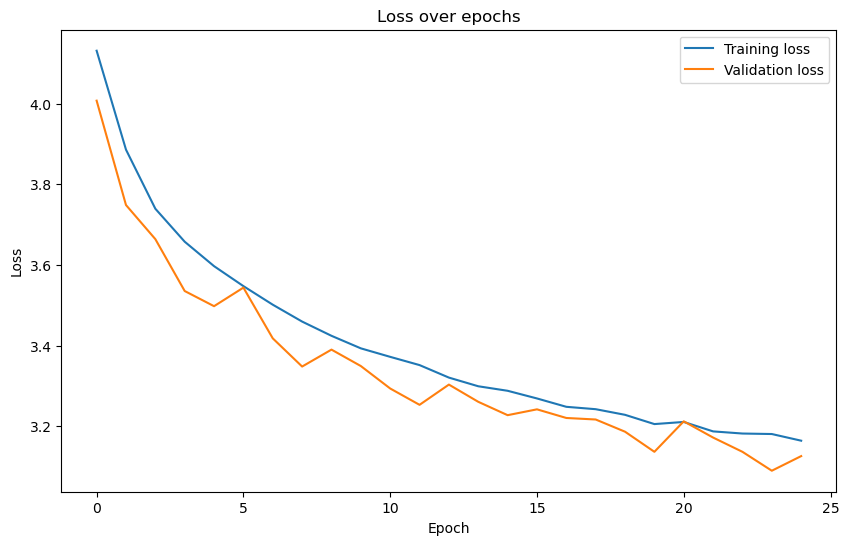

In [11]:
# Plotting the Training and Validation Loss Over Epochs
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## c. Transfer Learning

### Get EfficientNetB7 and Freeze Top Layers

In [12]:
# Function to apply transfer learning to a base model
def apply_transfer_learning(base_model, input_shape, num_classes, optimizer, loss, metrics):
    base_model.trainable = False  # Freeze layers

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())  # Flatten the output of the base model
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

### Prepare Frozen EfficientNetB7

In [13]:
# Create an instance of EfficientNetB7 with pre-trained weights for transfer learning
efficientnet_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Apply transfer learning to the base model
efficientnet_tl_model = apply_transfer_learning(efficientnet_model, input_shape, num_classes, optimizer, loss, metrics)

### Transfer EfficientNetB7

In [14]:
# Train EfficientNetB7 transfer learning model
history_efficientnet = efficientnet_tl_model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    verbose = 1
)

Epoch 1/25
1409/1409 [==============================] - 273s 178ms/step - loss: 53.1094 - accuracy: 0.0288 - val_loss: 59.3237 - val_accuracy: 0.0759
Epoch 2/25
1409/1409 [==============================] - 245s 174ms/step - loss: 54.3051 - accuracy: 0.0278 - val_loss: 62.2865 - val_accuracy: 0.0088
Epoch 3/25
1409/1409 [==============================] - 246s 175ms/step - loss: 53.4170 - accuracy: 0.0284 - val_loss: 50.2247 - val_accuracy: 0.0772
Epoch 4/25
1409/1409 [==============================] - 247s 175ms/step - loss: 53.9266 - accuracy: 0.0273 - val_loss: 52.2408 - val_accuracy: 0.0112
Epoch 5/25
1409/1409 [==============================] - 247s 175ms/step - loss: 54.6470 - accuracy: 0.0292 - val_loss: 44.7766 - val_accuracy: 0.0216
Epoch 6/25
1409/1409 [==============================] - 247s 176ms/step - loss: 54.0075 - accuracy: 0.0290 - val_loss: 54.5749 - val_accuracy: 0.0040
Epoch 7/25
1409/1409 [==============================] - 247s 175ms/step - loss: 53.0445 - accuracy: 

### Evaluate and Compare EfficientNetB7 to Custom Model

In [15]:
# Evaluate both models on the test set
custom_model_metrics = model.evaluate(
    test_generator,
    verbose = 1
    )
tl_model_metrics = efficientnet_tl_model.evaluate(
    test_generator,
    verbose = 1
    )

22619/22619 [==============================] - 1109s 49ms/step - loss: 56.5015 - accuracy: 0.0392


In [16]:
# Print out the evaluation results for both models
print(f'Custom Model: Loss = {custom_model_metrics[0]}, Accuracy = {custom_model_metrics[1]}')
print(f'Transfer Learning Model: Loss = {tl_model_metrics[0]}, Accuracy = {tl_model_metrics[1]}')

Custom Model: Loss = 3.1265921592712402, Accuracy = 0.2588973939418793
Transfer Learning Model: Loss = 56.5014533996582, Accuracy = 0.03921481966972351


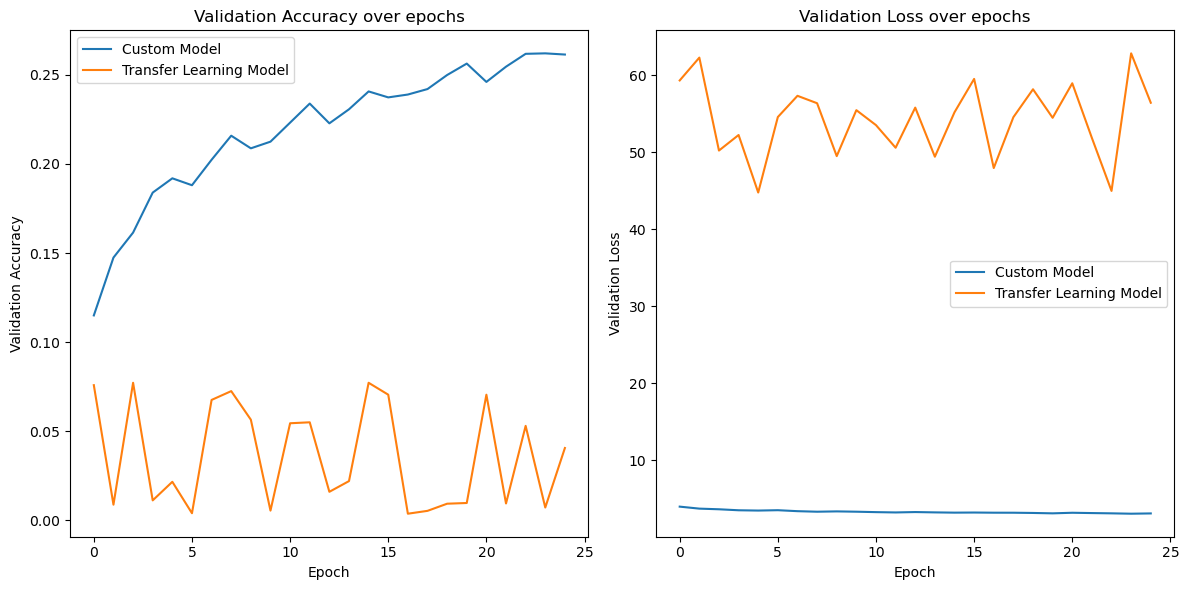

In [17]:
# Plot validation accuracy and loss for both models
plt.figure(figsize=(12,6))

# Plot validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Custom Model')
plt.plot(history_efficientnet.history['val_accuracy'], label='Transfer Learning Model')
plt.title('Validation Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

# Plot validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Custom Model')
plt.plot(history_efficientnet.history['val_loss'], label='Transfer Learning Model')
plt.title('Validation Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Question 3

### Prepare Data

In [18]:
# Prepare the dataset
X = np.linspace(-np.pi, np.pi, 1000)
Y = np.sin(X)

# Test the model
test_sine = np.linspace(-np.pi, np.pi, 1000)

### Define and Fit Previous MLP for Comparison

In [19]:
# Build the model using Keras
model = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

# Train the model
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

# Fit MLP to test data
MLP_predictions = model.predict(test_sine, verbose=1)

32/32 [==============================] - 0s 1ms/step


## LSTM

In [20]:
# LSTM Hyperparams
lstm_hyperparams = {
    "n_timesteps": 1,
    "n_features": 1,
    "activation": "tanh",
    "filters": (16, 32),
    "optimizer": "adam",
    "loss": "mse",
    "epochs": 100,
    "batch_size": 32,
    "loss_weights": 0.001
}

### Hyperparameters and Layer Reasoning:

1. **Number of LSTM Units**: The proposed Long Short-Term Memory (LSTM) model consists of two layers, with the first layer composed of 16 units and the second one containing 32 units. The choice of these unit counts is governed by the balancing act between the model's representational power and computational efficiency. The LSTM units, often colloquially referred to as 'memory cells', possess the ability to discern and retain relevant temporal patterns while discarding non-essential information, hence equipping the model with the capability to adapt and learn over time.

2. **Activation Function**: The activation function for our LSTM layers is the hyperbolic tangent, or 'tanh'. The tanh function is valued for its bi-directionality, being capable of mapping input data to outputs in the range of (-1, 1). This makes it a compelling choice for LSTM units due to its ability to capture and learn both positive and negative variations in data. Moreover, the tanh activation function is compatible with the cuDNN kernel, an optimization that can significantly accelerate training and inference processes. Given that our computational environment is equipped with a Graphics Processing Unit (GPU), leveraging this acceleration is pragmatically advantageous.

3. **Optimizer**: The Adam optimizer is employed for the training of our LSTM model. Adam is an optimization algorithm that adapts the learning rate for each weight in the model, typically leading to robust performance across various problems. This adaptive learning rate can result in quicker convergence and overall improved performance.

4. **Loss Function**: The loss function used in our model is Mean Squared Error (MSE), a common choice for regression problems. This function computes the average squared differences between the predicted and actual values, offering a clear measure of model prediction error.

5. **Epochs and Batch Size**: The model is trained for 100 epochs, with a batch size of 32. The number of epochs signifies how many times the learning algorithm will work through the entire training dataset. Batch size represents the number of training examples utilized in one iteration. The chosen values ensure a reasonable compromise between computational cost and the ability to generalize well.

6. **Loss Weights**: The goal of the question is to learn the sine function and thus, a scalar weight of 1 is assigned to the loss function, indicating that the model’s aim is to minimize the loss directly without any additional scaling.

7. **Number of Timesteps and Features**: The LSTM layers are configured to accept input data with one timestep and one feature. This is consistent with univariate time series prediction tasks, where we predict future values based on past values of a single series.

In [21]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(lstm_hyperparams["filters"][0], activation=lstm_hyperparams["activation"], input_shape=(lstm_hyperparams["n_timesteps"], lstm_hyperparams["n_timesteps"]), return_sequences=True),
    LSTM(lstm_hyperparams["filters"][1], activation=lstm_hyperparams["activation"]),
    Dense(1)
], name="Q3_Custom_LSTM")


### Model Architecture Summary:

Our model, an instantiation of Long Short-Term Memory (LSTM), is a class of recurrent neural networks (RNNs) renowned for their capacity to sustain long-term dependencies in sequential data. The model is implemented using the Keras Sequential API, which emphasizes clarity and reproducibility, facilitating an intuitive understanding of the model architecture and subsequent replication efforts.

1. **First LSTM Layer**: The inaugural layer of our model boasts 16 LSTM units, a configuration which reflects a harmonious balance between model complexity and computational efficiency. The configuration parameter return_sequences is set to True in this layer, enabling the layer to output full sequences of successive outputs for each timestep. This serves as a conduit for the sequential information flow into the subsequent LSTM layer.

2. **Second LSTM Layer**: This layer incorporates 32 LSTM units, an increment over the preceding layer, enhancing the model's capacity to learn more complex representations. Unlike the preceding layer, it is designed not to return sequences, focusing instead on delivering output from the final timestep, a key attribute necessary for downstream operations, especially when interfacing with non-sequential layers.

3. **Dense Layer**: The final layer of our network is a densely connected layer, equipped with a solitary unit. This layer lacks an explicit activation function, suggestive of a model tailored for regression tasks where unbounded continuous output is frequently required.

In [22]:
# Compile the model
lstm_model.compile(optimizer=lstm_hyperparams["optimizer"], loss=lstm_hyperparams["loss"], loss_weights=lstm_hyperparams["loss_weights"])

# Reshape the data to 3D for LSTM
X_reshaped = X.reshape(-1, 1, 1)
Y_reshaped = Y.reshape(-1, 1)

# Train the model
lstm_model.fit(X_reshaped, Y_reshaped, epochs=lstm_hyperparams["epochs"], batch_size=lstm_hyperparams["batch_size"], verbose=0)

# Test the model
test_input_reshaped = test_sine.reshape(-1, 1, 1)
LSTM_predictions = np.squeeze(lstm_model.predict(test_input_reshaped, verbose=0))

# Summarize the model architecture
lstm_model.summary()

Model: "Q3_Custom_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 16)             1152      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


### Number of Parameters in Each Layer:

Each layer in the model contributes a number of trainable parameters. Here's the breakdown for each layer:

1. **First LSTM layer**:
    - num_gates = 4
    - size_of_input = 1 (from the input shape)
    - size_of_output = 16 (from the number of units in this layer)
    - num_params = 4 * ((1 + 1) * 16 + 16^2) = 1152

</br>

2. **Second LSTM layer**:
    - num_gates = 4
    - size_of_input = 16 (output of the previous layer)
    - size_of_output = 32 (from the number of units in this layer)
    - num_params = 4 * ((16 + 1) * 32 + 32^2) = 6272

</br>

3. **Dense Layer**:
    - size_of_input = 32 (output of the previous layer)
    - size_of_output = 1 (from the number of units in this layer)
    - num_params = (32 * 1 + 1) = 33

</br>

### Total Model Parameters

The total number of trainable parameters in the model is the sum of the parameters in each layer:

1152 (First LSTM layer) + 6272 (Second LSTM layer) + 33 (Dense Layer) = **7,457**.


### Compare LSTM with Previous MLP

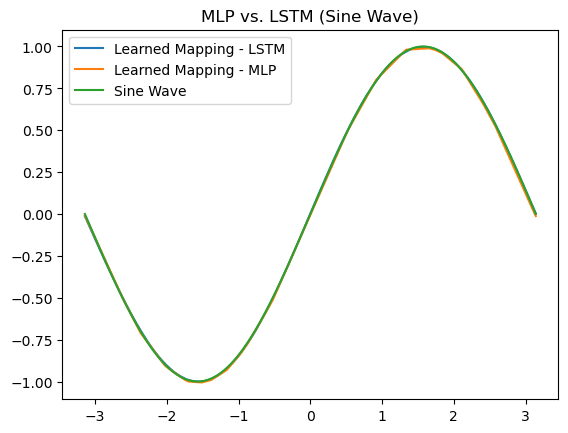

In [23]:
# Plot the learned mapping and compare it with the sine wave
plt.plot(test_sine, LSTM_predictions, label='Learned Mapping - LSTM')
plt.plot(test_sine, MLP_predictions, label='Learned Mapping - MLP')
plt.plot(test_sine, np.sin(test_sine), label='Sine Wave')
plt.title("MLP vs. LSTM (Sine Wave)")
plt.legend()
plt.show()

## GRU

In [24]:
# GRU Hyperparams
gru_hyperparams = {
    "n_timesteps": 1,
    "n_features": 1,
    "activation": "tanh",
    "filters": (16, 32),
    "optimizer": "adam",
    "loss": "mse",
    "epochs": 100,
    "batch_size": 32,
    "loss_weights": 0.001
}

### Hyperparameters and Layer Reasoning:

1. **Activation Function**:
The activation function tanh is used in this model. The hyperbolic tangent function or tanh is an activation function that maps the weighted inputs in the range (-1,1). This function is predominantly beneficial for cases where the model needs to learn from both positive and negative values, as it exhibits stronger gradients for a larger range of input values compared to the sigmoid function.

2. **Number of Filters**:
The term filters in this context represents the number of units or neurons in each of the GRU layers. It's a misnomer stemming from convolutional neural networks (CNNs) terminology. In the code, we have two GRU layers, the first with 16 units and the second with 32 units. The number of units in a layer affects the capacity of the model. More units allow the model to learn more complex representations, but also make the model more prone to overfitting.

3. **Optimizer**:
The optimizer is set to adam. Adam (Adaptive Moment Estimation) is a popular optimization algorithm in machine learning that uses adaptive learning rates to converge quickly. It combines the benefits of two other extensions of stochastic gradient descent: AdaGrad, which works well with sparse gradients, and RMSProp, which works well in online and non-stationary settings.

4. **Loss Function**:
The model uses mse or Mean Squared Error as the loss function. MSE is commonly used in regression problems and aims to minimize the average of the squares of the differences between the true and predicted values. The choice of MSE is likely due to the model being tasked to predict a continuous output.

5. **Epochs**:
Epochs are the number of times the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has updated the model's internal parameters. In this instance, the number of epochs is set to 100, indicating that the complete dataset will be passed through the model a hundred times.

6. **Batch Size**:
Batch size defines the number of samples that will be propagated through the network simultaneously. A lower batch size of 32 has been selected here, which typically provides a good balance between the memory limitations and the stochastic nature of the updates.

7. **Loss Weights**:
The loss_weights parameter is used to balance the importance of different loss functions in multi-output models. However, it seems to be incorrectly used in this case, as there is only one output and one loss function.

8. **Number of Time Steps and Features**:
The parameter n_timesteps stands for the number of time steps in the input sequence. A time step, in the domain of recurrent neural networks (RNNs) such as GRUs, symbolizes a single point in a temporal sequence of data. It is analogous to the concept of 'rows' in a non-temporal (regular tabular) dataset. It is crucial to understand that the selection of this parameter depends entirely on the nature of the data and the problem at hand. The use of a singular time step in this scenario might suggest that we are considering each data point independently, thus devoid of the influence of its historical context. n_features delineates the number of variables or features in the input dataset. In the simplest terms, a feature is an individual measurable attribute or property of a phenomenon being observed. Akin to n_timesteps, this parameter is also contingent on the structure of the data and the problem one is dealing with. In this context, the use of a single feature suggests a univariate analysis.

In [25]:
# Build the GRU model
gru_model = Sequential([
    GRU(gru_hyperparams["filters"][0], activation=gru_hyperparams["activation"], input_shape=(gru_hyperparams["n_timesteps"], gru_hyperparams["n_features"]), return_sequences=True),
    GRU(gru_hyperparams["filters"][1], activation=gru_hyperparams["activation"]),
    Dense(1)
], name="Q3_Custom_GRU")

### Model Architecture Summary:

The model is a recurrent neural network (RNN) employing gated recurrent units (GRUs), organized in a sequential fashion. The use of the Sequential model in Keras allows for the linear stacking of layers, wherein each layer has exactly one input tensor and one output tensor.

1. **First GRU Layer**: This is the initial layer in the sequence which takes in input of shape (n_timesteps, n_features), corresponding to the number of time steps and the number of features. It consists of 16 units (or neurons), as specified by filters[0]. The 'return_sequences' parameter is set to True, which means that this layer returns the full sequence output, providing a sequence of 16-dimensional vectors as output. This is essential to allow the next GRU layer to operate on sequence data. The activation function used is tanh.

2. **Second GRU Layer**: The second layer in the sequence is also a GRU layer with 32 units (filters[1]), following the first GRU layer. The return_sequences parameter defaults to False, so this layer returns output from only the last time step, outputting a 32-dimensional vector. The activation function is tanh for this layer as well.

3. **Dense Layer**: Following the two GRU layers, there is a dense (or fully connected) layer. It has only 1 unit, meaning it generates a single output for each sample. The default activation function for a Dense layer is linear, which means the output is a simple linear function of the input.

In [26]:
# Compile the model
gru_model.compile(optimizer=gru_hyperparams["optimizer"], loss=gru_hyperparams["loss"], loss_weights=gru_hyperparams["loss_weights"])

# Train the model
gru_model.fit(X_reshaped, Y_reshaped, epochs=gru_hyperparams["epochs"], batch_size=gru_hyperparams["batch_size"], verbose=0)

# Test the model
GRU_predictions = gru_model.predict(test_input_reshaped, verbose=0)

# Summarize the model architecture
gru_model.summary()

Model: "Q3_Custom_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 16)             912       
                                                                 
 gru_1 (GRU)                 (None, 32)                4800      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,745
Trainable params: 5,745
Non-trainable params: 0
_________________________________________________________________


### Number of Parameters in Each Layer:

Number of Parameters in Each Layer:
Each layer in the model contributes to a number of trainable parameters. Here's the breakdown for each layer:

1. **First GRU layer**:
    - num_gates = 3
    - size_of_input = 1 (from the input shape)
    - size_of_output = 16 (from the number of units in this layer)
    - num_params = 3 * ((1 + 1) * 16 + 16^2) = 912

</br>

2. **Second GRU layer**:
    - num_gates = 3
    - size_of_input = 16 (output of the previous layer)
    - size_of_output = 32 (from the number of units in this layer)
    - num_params = 3 * ((16 + 1) * 32 + 32^2) = 4800

</br>

3. **Dense Layer**:
    - size_of_input = 32 (output of the previous layer)
    - size_of_output = 1 (from the number of units in this layer)
    - num_params = (32 * 1 + 1) = 33

</br>

### Total Model Parameters

The total number of trainable parameters in the model is the sum of the parameters in each layer:

912 (First GRU layer) + 4800 (Second GRU layer) + 33 (Dense Layer) = **5,745**.

### Compare GRU with Previous MLP

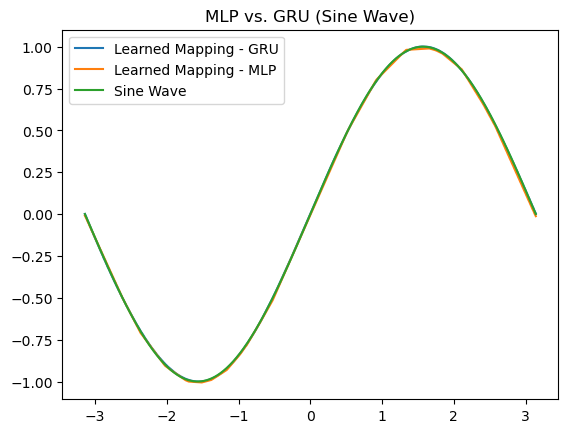

In [27]:
# Plot the learned mapping and compare it with the sine wave
plt.plot(test_sine, GRU_predictions, label='Learned Mapping - GRU')
plt.plot(test_sine, MLP_predictions, label='Learned Mapping - MLP')
plt.plot(test_sine, np.sin(test_sine), label='Sine Wave')
plt.title("MLP vs. GRU (Sine Wave)")
plt.legend()
plt.show()

# Question 4

### Summary of analysis

We plan to analyze the FairFace dataset, a large and balanced dataset containing face images, meticulously labeled for fairness across various demographic attributes such as race, age, and gender. In our analysis, we aim to focus on the 'gender' attribute.

- Data Distribution: We'll first investigate the distribution of gender classes within the dataset to identify any potential biases. This involves looking at the frequency of each unique gender class and visualizing these frequencies for better comprehension.

- Model Training and Performance: We'll train a deep learning model on the data and evaluate its performance on the classification of different genders. This includes examining the overall accuracy and also checking the model's performance (precision, recall, f1-score) on each racial class.

- Bias Analysis: We'll evaluate whether the model shows any signs of unfair bias in its predictions. This involves checking if the model's error rates are significantly higher for any particular racial class compared to others.

### Get file locations

In [28]:
# Read the training, validation and test data from text files into respective DataFrames
train_df_q4 = pd.read_csv(fair_face_path + "train_labels.csv", sep=",")
val_df_q4 = pd.read_csv(fair_face_path + "val_labels.csv", sep=",")

# Get num_classes_q4
num_classes_q4 = len(train_df_q4["gender"].unique())

# Show top of train_df_q4
train_df_q4.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


### Plot Distribution of Classes

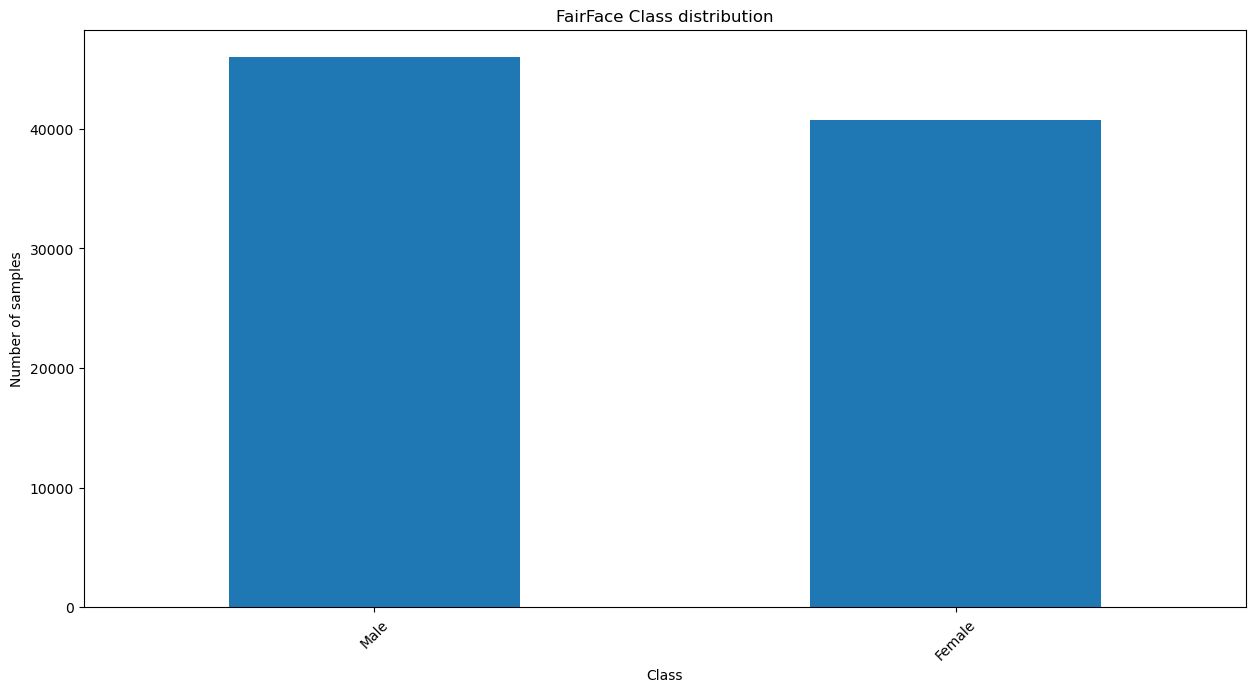

In [29]:
# Calculate the frequency of each class in the target column of the training set, to understand class distribution
class_counts = train_df_q4['gender'].value_counts()

# Plot class distribution for visualization
plt.figure(figsize=(15, 7.5))
class_counts.plot(kind='bar')
plt.title('FairFace Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.xticks(rotation=45)
plt.show()

### Prepare Images for CNN

In [30]:
# Set the batch size for the generators
batch_size = 32

# Create data generators for training, validation and testing
# These will be used to supply data to the model during training/validation/testing
train_generator_q4 = train_datagen.flow_from_dataframe(
    dataframe=train_df_q4,
    directory=os.path.join(fair_face_path),
    x_col="file",
    y_col="gender",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

val_generator_q4 = valid_test_datagen.flow_from_dataframe(
    dataframe=val_df_q4,
    directory=os.path.join(fair_face_path),
    x_col="file",
    y_col="gender",
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 86744 validated image filenames belonging to 2 classes.
Found 10954 validated image filenames belonging to 2 classes.


### Hyperparameters

In [31]:
# Training paramaters
fair_face_hyperparams = {
    "input_shape": (100, 100, 3),
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "metrics": ["accuracy"],
    "epochs": 25,
    "regs": (0.00001, 0.00001)
}

### Create and Fit CNN

In [32]:
# Create a MirroredStrategy for distributed training across multiple GPUs
strategy = tf.distribute.MirroredStrategy(devices=gpu_names)

def create_model(input_shape, num_classes, regs):

    model = Sequential([

        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l1_l2(l1=regs[0], l2=regs[1])),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), padding='same', activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),

    ], name="Q2_Custom_CNN")

    model.compile(optimizer=fair_face_hyperparams["optimizer"], loss=fair_face_hyperparams["loss"], metrics=fair_face_hyperparams["metrics"])

    return model

# Open the strategy scope
with strategy.scope():
    model = create_model(fair_face_hyperparams["input_shape"], num_classes_q4, fair_face_hyperparams["regs"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


### Model Justification

CNNs, the architecture we have chosen, is especially suitable for the gender attribute in facial datasets for several reasons:

1. **Hierarchical Feature Learning**: CNNs are capable of learning hierarchical feature representations which are highly beneficial when distinguishing complex patterns. In the context of gender identification, there are both macro and micro-level facial characteristics that can help identify a person's gender. Macro-level features might include overall face shape, while micro-level features could involve details around the eyes, nose, or mouth. CNNs can learn and make use of both types of features, making them suitable for this task.

2. **Position Invariance**: CNNs provide position invariance, which means that they can recognize a feature regardless of its position in the image. This is crucial in gender classification as people's faces can appear in various positions and orientations within an image.

3. **Edge Detection**: The initial layers of a CNN are usually excellent at edge detection, which can be important when looking at facial features. Distinctive racial features often involve the structure and contour of the face, and thus edge detection can be instrumental.

4. **Training with Imbalanced Data**: CNNs can be effectively trained using techniques such as class weighting or oversampling when dealing with imbalanced data. It's possible that some racial groups are underrepresented in a facial dataset. Implementing these techniques can ensure fairer representation and performance across genders.

5. **Robustness to Variations**: CNNs are robust to variations and changes in images such as lighting conditions, shadows, and facial expressions, which are frequent in facial datasets. This robustness is crucial for gender classification as these variations don't alter a person's gender.

In conclusion, the architecture is suitable for gender classification as it is adept at extracting complex, hierarchical features from images and is capable of dealing with variations in the images.

In [33]:
# Train CNN from scratch
history = model.fit(
    train_generator_q4,
    steps_per_epoch=train_generator_q4.n // train_generator_q4.batch_size,
    epochs=fair_face_hyperparams["epochs"],
    validation_data=val_generator_q4,
    validation_steps=val_generator_q4.n // val_generator_q4.batch_size,
    verbose = 1
)

Epoch 1/25
2710/2710 [==============================] - 224s 82ms/step - loss: 0.6402 - accuracy: 0.6220 - val_loss: 0.5711 - val_accuracy: 0.7052
Epoch 2/25
2710/2710 [==============================] - 219s 81ms/step - loss: 0.5728 - accuracy: 0.6918 - val_loss: 0.5152 - val_accuracy: 0.7325
Epoch 3/25
2710/2710 [==============================] - 220s 81ms/step - loss: 0.5360 - accuracy: 0.7184 - val_loss: 0.4694 - val_accuracy: 0.7614
Epoch 4/25
2710/2710 [==============================] - 217s 80ms/step - loss: 0.5070 - accuracy: 0.7407 - val_loss: 0.4343 - val_accuracy: 0.7836
Epoch 5/25
2710/2710 [==============================] - 220s 81ms/step - loss: 0.4905 - accuracy: 0.7515 - val_loss: 0.4144 - val_accuracy: 0.7986
Epoch 6/25
2710/2710 [==============================] - 217s 80ms/step - loss: 0.4755 - accuracy: 0.7613 - val_loss: 0.4187 - val_accuracy: 0.7995
Epoch 7/25
2710/2710 [==============================] - 222s 82ms/step - loss: 0.4630 - accuracy: 0.7685 - val_loss: 0

### Model Evaluation

In [34]:
# Get the true labels
true_labels = val_generator_q4.classes

# Predict probabilities for each class
predictions_prob = model.predict(val_generator_q4)

# Get the class with highest probability for each sample
predicted_labels = np.argmax(predictions_prob, axis=1)

343/343 [==============================] - 11s 27ms/step


#### Confusion Matrix

Performance Metrics:

---------------------------

Accuracy: 84.04%

---------------------------

ROC AUC Score: 0.84

---------------------------



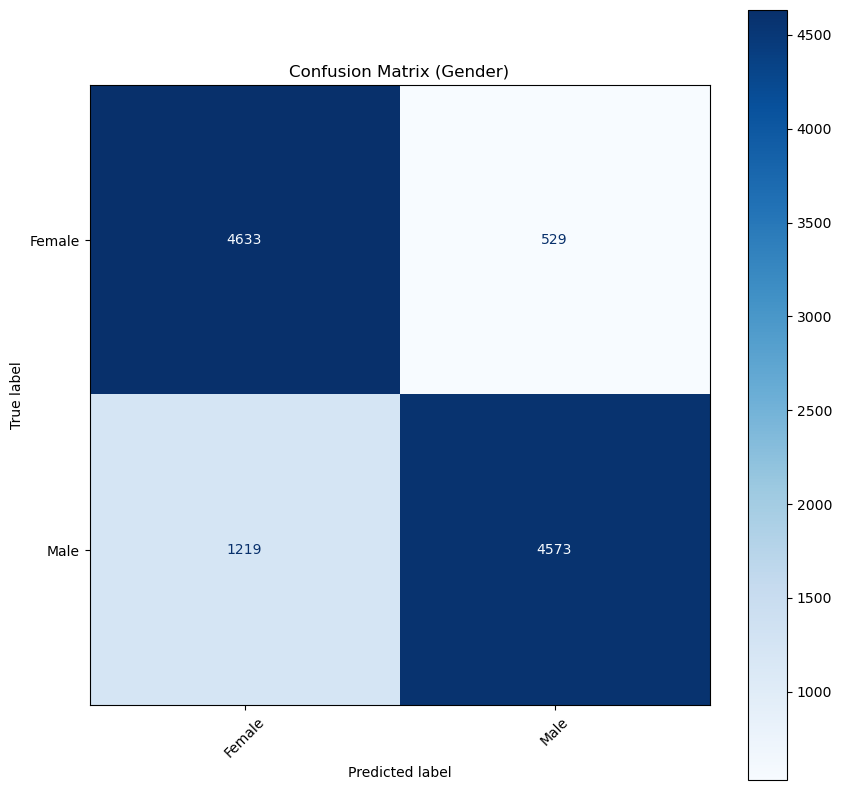

In [38]:
# Print title
print("Performance Metrics:")
print("\n---------------------------\n")

# Calculate Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy*100:.2f}%')
print("\n---------------------------\n")

# Calculate ROC AUC
roc_auc = roc_auc_score(true_labels, predicted_labels)
print(f'ROC AUC Score: {roc_auc:.2f}')
print("\n---------------------------\n")

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator_q4.class_indices.keys())

# Create a new figure and set its size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the confusion matrix on the created axes
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix (Gender)")
plt.xticks(rotation=45)

# Show the figure
plt.show()


### Bias and Fairness Evaluation (Metric: Disparate Impact Ratio)

In [36]:
# define privileged and unprivileged groups
privileged_groups = [{'gender': 1}]
unprivileged_groups = [{'gender': 0}]

# assuming gender_values is a list or array with the correct gender attribute for each instance
actual_df = pd.DataFrame(data={'gender': val_generator_q4.classes, 'labels': true_labels})
predicted_df = pd.DataFrame(data={'gender': val_generator_q4.classes, 'labels': predicted_labels})

# Convert the DataFrames to BinaryLabelDataset
dataset_actual = BinaryLabelDataset(df=actual_df, label_names=['labels'], protected_attribute_names=['gender'])
dataset_pred = BinaryLabelDataset(df=predicted_df, label_names=['labels'], protected_attribute_names=['gender'])

# Compute ClassificationMetric
metric = ClassificationMetric(dataset_actual, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

disparate_impact = metric.disparate_impact()
print("Disparate Impact Ratio: ", round(disparate_impact, 3))

Disparate Impact Ratio:  0.13


In the evaluation conducted on our machine learning model, the Disparate Impact Ratio (DIR) was used as a measure to assess fairness, with a particular emphasis on potential gender bias. The DIR is, in straightforward terms, a metric representing the ratio of positive outcomes (identified by gender=1) for the unprivileged group (males in our dataset), divided by the rate of favorable outcomes for the privileged group (females).

Guidelines proposed by the AIF360 tool suggest an acceptable lower limit for DIR is 0.8. This indicates that if males are receiving a favorable outcome (identified by gender=1) less than 80% of the time compared to females, this is considered a disparate impact violation.

However, our study discovered a Disparate Impact Ratio of 0.13. This outcome indicates a significant bias in our model's predictions, disproportionately favoring females over males. In more precise terms, the low DIR of 0.13 illustrates that males are achieving positive outcomes at a rate significantly lower than 80% of their female counterparts, revealing a clear disparate impact violation.

These findings highlight the need for techniques that can address this observed bias in future model iterations. This may encompass pre-processing methods to diminish bias in the data, altering the model to reduce bias, or post-processing the model's predictions to correct bias. The chosen method should conscientiously consider the trade-off between model accuracy and the enhancement of fairness. As achieving fairness in machine learning is an iterative and ongoing process, it often calls for consistent monitoring and adjustments.

In [37]:
# Ha!